# Over-fitting and model selection

## Introduction

In this notebook, we present the problem of over-fitting a model to data. We consider observations generated from noisy observations of the sinus function. We see how polynomial curve fitting is not appropriate when the number of coefficients increases.

## References

* Bishop Christopher M., 1995, Neural networks for pattern recognition. Figure 1.4, page 7

## Compute the data

In [1]:
import openturns as ot
import openturns.viewer as otv
import pylab as pl

In [2]:
ot.RandomGenerator.SetSeed(0)

In [3]:
palette = ot.Drawable_BuildDefaultPalette(10)

We define the function that we are going to approximate. 

In [4]:
g = ot.SymbolicFunction(["x"], ["sin(2*pi_*x)"])

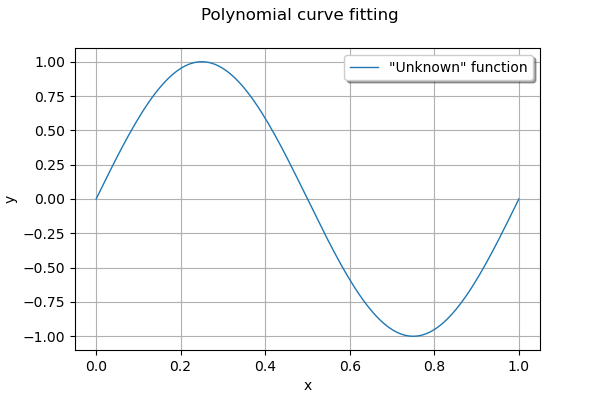

In [5]:
graph = ot.Graph("Polynomial curve fitting", "x", "y", True, "topright")
# The "unknown" function
curve = g.draw(0, 1)
curve.setColors([palette[0]])
curve.setLegends(['"Unknown" function'])
graph.add(curve)
graph

This seems a nice, regular, function to approximate with polynomials.

In [6]:
def linearSample(xmin, xmax, npoints):
    """Returns a sample created from a regular grid
    from xmin to xmax with npoints points."""
    step = (xmax - xmin) / (npoints - 1)
    rg = ot.RegularGrid(xmin, step, npoints)
    vertices = rg.getVertices()
    return vertices

We consider 10 points in the interval [0,1].

In [7]:
n_train = 10
x_train = linearSample(0, 1, n_train)

Assume that the observations are noisy and that the noise is a gaussian with zero mean and a small standard deviation.

In [8]:
noise = ot.Normal(0, 0.1)
noiseSample = noise.getSample(n_train)

The following computes the observation depending as the sum of the function value and the noise. The couple (`x_train`,`y_train`) is the training set: it is used to compute the coefficients of the polynomial model. 

In [9]:
y_train = g(x_train) + noiseSample

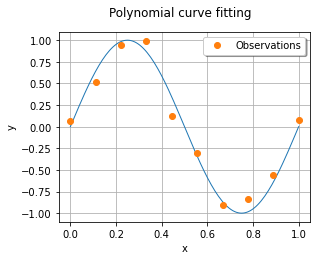

In [10]:
graph = ot.Graph("Polynomial curve fitting", "x", "y", True, "topright")
# The "unknown" function
curve = g.draw(0, 1)
curve.setColors([palette[0]])
graph.add(curve)
# Training set
cloud = ot.Cloud(x_train, y_train)
cloud.setPointStyle("circle")
cloud.setLegend("Observations")
cloud.setColor(palette[1])
graph.add(cloud)
view = otv.View(graph, figure_kw={"figsize": (4.5, 3.5)})
view.save("overfitting-function-sample.pdf")

## Compute the coefficients of the polynomial decomposition

Let $y\in\mathbb{R}^n$ be a vector of observations. 

The polynomial model is 
$$
P(x) = \beta_0 + \beta_1 x + ... + \beta_p x^p,
$$
for any $x\in\mathbb{R}$, where $p$ is the polynomial degree and $\beta\in\mathbb{R}^{p+1}$ is the vector of the coefficients of the model. 

Let $n$ be the training sample size and let $x_1,...,x_n\in\mathbb{R}$ be the abscissas of the training set. 
The design matrix $X\in\mathbb{R}^{n\times (p+1)}$ is 
$$
x_{i,j} = x^j_i,
$$
for $i=1,...,n$ and $j=0,...,p$.

The least squares solution is:
$$
\beta^\star = \textrm{argmin}_{\beta\in\mathbb{R}^{p+1}} \|X\beta - y\|_2^2.
$$

In order to approximate the function with polynomials up to degree 4, we create a list of strings containing the associated monomials. We do not include a constant in the polynomial basis, as this constant term is automatically included in the model by the `LinearLeastSquares` class. We perform the loop from 1 up to `total_degree` (but the `range` function takes `total_degree+1` as the second input argument). 

In [11]:
total_degree = 4
polynomialCollection = ["x^%d" % (degree) for degree in range(1, total_degree + 1)]
polynomialCollection

['x^1', 'x^2', 'x^3', 'x^4']

Given the list of strings, we create a symbolic function which computes the values of the monomials. 

In [12]:
basis = ot.SymbolicFunction(["x"], polynomialCollection)
basis

class=SymbolicFunction name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x,y0,y1,y2,y3] evaluationImplementation=class=SymbolicEvaluation name=Unnamed inputVariablesNames=[x] outputVariablesNames=[y0,y1,y2,y3] formulas=[x^1,x^2,x^3,x^4] gradientImplementation=class=SymbolicGradient name=Unnamed evaluation=class=SymbolicEvaluation name=Unnamed inputVariablesNames=[x] outputVariablesNames=[y0,y1,y2,y3] formulas=[x^1,x^2,x^3,x^4] hessianImplementation=class=SymbolicHessian name=Unnamed evaluation=class=SymbolicEvaluation name=Unnamed inputVariablesNames=[x] outputVariablesNames=[y0,y1,y2,y3] formulas=[x^1,x^2,x^3,x^4]

In [13]:
designMatrix = basis(x_train)
designMatrix

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=10 dimension=4 description=[y0,y1,y2,y3] data=[[0,0,0,0],[0.111111,0.0123457,0.00137174,0.000152416],[0.222222,0.0493827,0.0109739,0.00243865],[0.333333,0.111111,0.037037,0.0123457],[0.444444,0.197531,0.0877915,0.0390184],[0.555556,0.308642,0.171468,0.0952599],[0.666667,0.444444,0.296296,0.197531],[0.777778,0.604938,0.470508,0.36595],[0.888889,0.790123,0.702332,0.624295],[1,1,1,1]]

In [14]:
myLeastSquares = ot.LinearLeastSquares(designMatrix, y_train)
myLeastSquares.run()

In [15]:
responseSurface = myLeastSquares.getMetaModel()

The couple (`x_test`,`y_test`) is the test set: it is used to assess the quality of the polynomial model with points that the training step did not see.

In [16]:
n_test = 50
x_test = linearSample(0, 1, n_test)
y_test = responseSurface(basis(x_test))

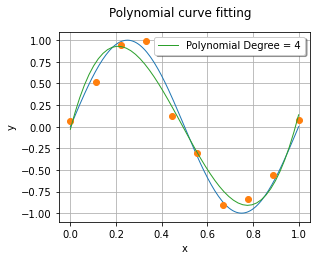

In [17]:
graph = ot.Graph("Polynomial curve fitting", "x", "y", True, "topright")
# The "unknown" function
curve = g.draw(0, 1)
curve.setColors([palette[0]])
graph.add(curve)
# Training set
cloud = ot.Cloud(x_train, y_train)
cloud.setPointStyle("circle")
cloud.setColor(palette[1])
graph.add(cloud)
# Predictions
curve = ot.Curve(x_test, y_test)
curve.setLegend("Polynomial Degree = %d" % (total_degree))
curve.setColor(palette[2])
graph.add(curve)
view = otv.View(graph, figure_kw={"figsize": (4.5, 3.5)})
view.save("overfitting-polynomial-degree-4.pdf")

For each observation in the training set, the error is the vertical distance between the model and the observation.

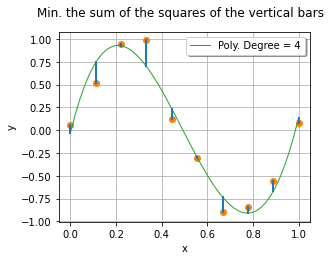

In [18]:
graph = ot.Graph(
    "Min. the sum of the squares of the vertical bars",
    "x",
    "y",
    True,
    "topright",
)
# Training set observations
cloud = ot.Cloud(x_train, y_train)
cloud.setPointStyle("circle")
cloud.setColor(palette[1])
graph.add(cloud)
# Predictions
curve = ot.Curve(x_test, y_test)
curve.setLegend("Poly. Degree = %d" % (total_degree))
curve.setColor(palette[2])
graph.add(curve)
# Errors
ypredicted_train = responseSurface(basis(x_train))
for i in range(n_train):
    curve = ot.Curve([x_train[i], x_train[i]], [y_train[i], ypredicted_train[i]])
    curve.setColor(palette[0])
    curve.setLineWidth(2)
    graph.add(curve)
view = otv.View(graph, figure_kw={"figsize": (4.5, 3.5)})
view.save("overfitting-polynomial-degree-4-bars.pdf")

The least squares method minimizes the sum of the squared errors i.e. the sum of the squares of the lengths of the vertical segments.

We gather the previous computation in two different functions. The `myPolynomialDataFitting` function computes the least squares solution and `myPolynomialCurveFittingGraph` plots the results.

In [19]:
def myPolynomialDataFitting(total_degree, x_train, y_train):
    """Computes the polynomial curve fitting
    with given total degree.
    This is for learning purposes only: please consider a serious metamodel
    for real applications, e.g. polynomial chaos or kriging."""
    polynomialCollection = ["x^%d" % (degree) for degree in range(1, total_degree + 1)]
    basis = ot.SymbolicFunction(["x"], polynomialCollection)
    designMatrix = basis(x_train)
    myLeastSquares = ot.LinearLeastSquares(designMatrix, y_train)
    myLeastSquares.run()
    responseSurface = myLeastSquares.getMetaModel()
    return responseSurface, basis

In [20]:
def myPolynomialCurveFittingGraph(total_degree, x_train, y_train):
    """Returns the graphics for a polynomial curve fitting
    with given total degree"""
    responseSurface, basis = myPolynomialDataFitting(total_degree, x_train, y_train)
    # Graphics
    n_test = 100
    x_test = linearSample(0, 1, n_test)
    ypredicted_test = responseSurface(basis(x_test))
    # Graphics
    graph = ot.Graph("Polynomial curve fitting", "x", "y", True, "topright")
    # The "unknown" function
    curve = g.draw(0, 1)
    curve.setColors([palette[0]])
    graph.add(curve)
    # Training set
    cloud = ot.Cloud(x_train, y_train)
    cloud.setPointStyle("circle")
    cloud.setColor(palette[1])
    cloud.setLegend("N=%d" % (x_train.getSize()))
    graph.add(cloud)
    # Predictions
    curve = ot.Curve(x_test, ypredicted_test)
    curve.setLegend("Polynomial Degree = %d" % (total_degree))
    curve.setColor(palette[2])
    graph.add(curve)
    return graph

In order to see the effect of the polynomial degree, we compare the polynomial fit with degrees equal to 0 (constant), 1 (linear), 3 (cubic) and 9 (ninic ?).

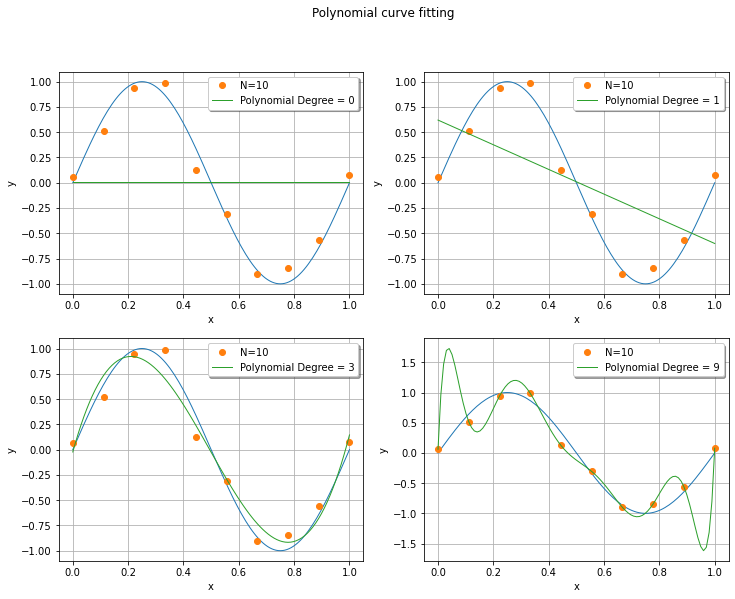

In [21]:
fig = pl.figure(figsize=(12, 9))
_ = fig.suptitle("Polynomial curve fitting")
ax_1 = fig.add_subplot(2, 2, 1)
_ = ot.viewer.View(
    myPolynomialCurveFittingGraph(0, x_train, y_train), figure=fig, axes=[ax_1]
)
ax_2 = fig.add_subplot(2, 2, 2)
_ = ot.viewer.View(
    myPolynomialCurveFittingGraph(1, x_train, y_train), figure=fig, axes=[ax_2]
)
ax_3 = fig.add_subplot(2, 2, 3)
_ = ot.viewer.View(
    myPolynomialCurveFittingGraph(3, x_train, y_train), figure=fig, axes=[ax_3]
)
ax_4 = fig.add_subplot(2, 2, 4)
_ = ot.viewer.View(
    myPolynomialCurveFittingGraph(9, x_train, y_train),
    figure=fig,
    axes=[ax_4],
)
pl.savefig("overfitting-polynomial-degree-various.pdf")

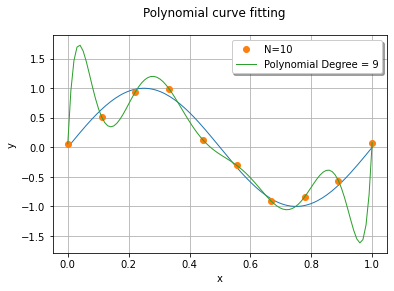

In [22]:
view = otv.View(myPolynomialCurveFittingGraph(9, x_train, y_train))
view.save("overfitting-polynomial-degree-9.pdf")

When the polynomial degree is low, the fit is satisfying. The polynomial is close to the observations, although there is still some residual error. 

However, when the polynomial degree is high, it produces large oscillations which significantly deviate from the true function. This is *overfitting*. This is a pity, given the fact that the polynomial *exactly* interpolates the observations: the residuals are zeroed. 

If the locations of the x abscissas could be changed, then the oscillations could be made smaller. This is the method used in gaussian quadrature, where the nodes of interpolation are made closer on the left and right bounds. In our situation, we make the asssumption that these abscissas cannot be changed: the most obvious choice is to limit the degree of the polynomial. Another possibility is to include a regularization into the least squares solution. 

## Root mean squared error

In order to assess the quality of the polynomial fit, we create a second dataset, the *test set* and compare the value of the polynomial with the test observations. 

In [23]:
sqrt = ot.SymbolicFunction(["x"], ["sqrt(x)"])

In order to see how close the model is to the observations, we compute the root mean square error. 

First, we create a degree 4 polynomial which fits the data.

In [24]:
total_degree = 4
responseSurface, basis = myPolynomialDataFitting(total_degree, x_train, y_train)

Then we create a test set, with the same method as before.

In [25]:
def createDataset(n):
    x = linearSample(0, 1, n)
    noiseSample = noise.getSample(n)
    y = g(x) + noiseSample
    return x, y

In [26]:
n_test = 100
x_test, y_test = createDataset(n_test)

On this test set, we evaluate the polynomial.

In [27]:
ypredicted_test = responseSurface(basis(x_test))

The vector of residuals is the vector of the differences between the observations and the predictions. 

In [28]:
residuals = y_test.asPoint() - ypredicted_test.asPoint()

The `normSquare` method computes the square of the Euclidian norm (i.e. the 2-norm). We divide this by the test sample size (so as to compare the error for different sample sizes) and compute the square root of the result (so that the result has the same unit as y).

In [29]:
RMSE = sqrt([residuals.normSquare() / n_test])[0]
RMSE

0.1446476675291099

The following function gathers the RMSE computation to make the experiment easier.

In [30]:
def computeRMSE(responseSurface, basis, x, y):
    ypredicted = responseSurface(basis(x))
    residuals = y.asPoint() - ypredicted.asPoint()
    RMSE = sqrt([residuals.normSquare() / n_test])[0]
    return RMSE

In [31]:
maximum_degree = 10
RMSE_train = ot.Sample(maximum_degree, 1)
RMSE_test = ot.Sample(maximum_degree, 1)
for total_degree in range(maximum_degree):
    responseSurface, basis = myPolynomialDataFitting(total_degree, x_train, y_train)
    RMSE_train[total_degree, 0] = computeRMSE(responseSurface, basis, x_train, y_train)
    RMSE_test[total_degree, 0] = computeRMSE(responseSurface, basis, x_test, y_test)

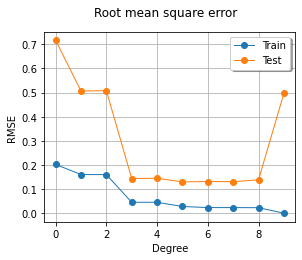

In [32]:
degreeSample = ot.Sample([[x] for x in range(maximum_degree)])
graph = ot.Graph("Root mean square error", "Degree", "RMSE", True, "topright")
# Train
cloud = ot.Curve(degreeSample, RMSE_train)
cloud.setColor(palette[0])
cloud.setLegend("Train")
cloud.setPointStyle("circle")
graph.add(cloud)
# Test
cloud = ot.Curve(degreeSample, RMSE_test)
cloud.setColor(palette[1])
cloud.setLegend("Test")
cloud.setPointStyle("circle")
graph.add(cloud)
view = otv.View(graph, figure_kw={"figsize": (4.5, 3.5)})
view.save("overfitting-RMSE.pdf")

We see that the RMSE on the train set continuously decreases, reaching zero when the polynomial degree is so that the number of coefficients is equal to the train dataset sample size. In this extreme situation, the least squares solution is equivalent to solving a linear system of equations: this leads to a zero residual.

On the test set however, the RMSE decreases, reaches a flat region, then increases dramatically when the degree is equal to 9. Hence, limiting the polynomial degree limits overfitting.

## Increasing the training set

We wonder what happens when the training dataset size is increased.

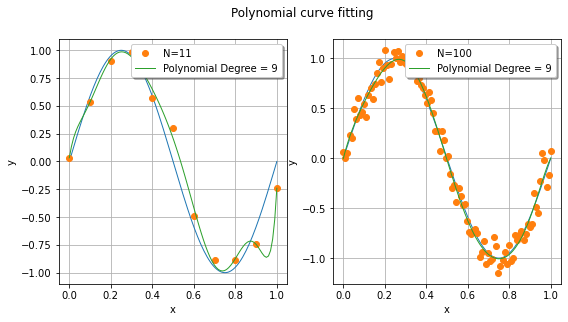

In [33]:
total_degree = 9
fig = pl.figure(figsize=(9.0, 4.5))
_ = fig.suptitle("Polynomial curve fitting")
#
ax_1 = fig.add_subplot(1, 2, 1)
n_train = 11
x_train, y_train = createDataset(n_train)
_ = ot.viewer.View(
    myPolynomialCurveFittingGraph(total_degree, x_train, y_train),
    figure=fig,
    axes=[ax_1],
)
#
n_train = 100
x_train, y_train = createDataset(n_train)
ax_2 = fig.add_subplot(1, 2, 2)
_ = ot.viewer.View(
    myPolynomialCurveFittingGraph(total_degree, x_train, y_train),
    figure=fig,
    axes=[ax_2],
)
pl.savefig("overfitting-increase-sample.pdf")

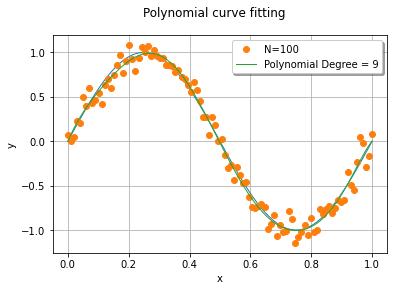

In [34]:
view = ot.viewer.View(
    myPolynomialCurveFittingGraph(total_degree, x_train, y_train))
pl.savefig("overfitting-increase-sample-degree-9.pdf")

We see that the polynomial oscillates with a dataset with size 11, but does not with the larger dataset: increasing the training dataset mitigates the oscillations. 